# Analyse results

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

from matplotlib.gridspec import GridSpec

## Load data

In [39]:
df = pd.read_csv("../data/all_results.csv", index_col=0, parse_dates=True, header=[0,1,2])
df.head()

tmin = {
    "Netherlands": "2016-09-23",
    "USA": "2017-01-18",
    "Germany": "2017-01-01",
    "Sweden_1": "2016-01-05",
    "Sweden_2": "2016-01-05",
}

tmax = {
    "Netherlands": "2020-11-27",
    "USA": "2021-12-31",
    "Germany": "2021-12-31",
    "Sweden_1": "2020-12-29",
    "Sweden_2": "2020-12-29",
}

## Plot the heads

In [40]:
wells = df.columns.get_level_values(1).unique()
heads = []
for well in wells:
    head = pd.read_csv("../data/{}/heads_full.csv".format(well), 
                       index_col=0, parse_dates=True).squeeze().dropna()
    head.index = head.index.round("D")    
    head.name = well
    heads.append(head.loc[~head.index.duplicated()])

heads = pd.concat(heads, axis=1)
heads

,USA,Netherlands,Germany,Sweden_1,Sweden_2
2000-01-01,NaN,11.24,NaN,NaN,NaN
2000-01-02,NaN,11.24,NaN,NaN,NaN
2000-01-03,NaN,11.23,NaN,NaN,NaN
2000-01-04,NaN,11.26,NaN,NaN,NaN
2000-01-05,NaN,11.24,NaN,NaN,NaN
...,...,...,...,...,...
2021-12-27,152.288936,NaN,374.79,NaN,NaN
2021-12-28,152.310271,NaN,374.83,NaN,NaN
2021-12-29,152.319415,NaN,374.94,NaN,NaN
2021-12-30,152.331606,NaN,375.07,NaN,NaN


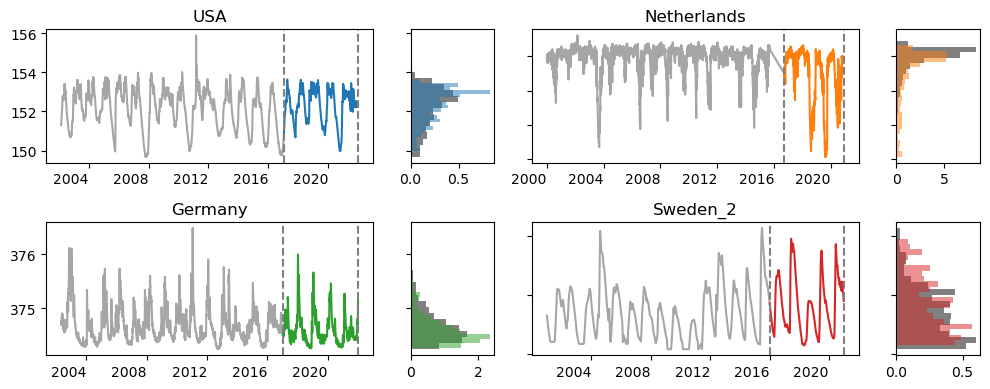

In [41]:
fig = plt.figure(figsize=(10,4))

gs = GridSpec(2, 8, figure=fig)

ax0 = fig.add_subplot(gs[0, 0:3])
ax1 = fig.add_subplot(gs[0, 3], sharey=ax0)

ax2 = fig.add_subplot(gs[0, 4:7])
ax3 = fig.add_subplot(gs[0, 7], sharey=ax2)

ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3], sharey=ax4)

ax6 = fig.add_subplot(gs[1, 4:7])
ax7 = fig.add_subplot(gs[1, 7], sharey=ax6)

# ax8 = fig.add_subplot(gs[1:3, 2:6])
# ax8.set_yticks([])
# ax8.set_xticks([])

kde_axes = [ax1, ax3, ax5, ax7]

for i, (well, ax) in enumerate(zip(wells.drop("Sweden_1"), [ax0, ax2, ax4, ax6])):
    heads.loc[:tmin[well], well].dropna().plot(ax=ax, color="gray", alpha=0.7, x_compat=True)
    heads.loc[tmin[well]:, well].dropna().plot(ax=ax, color="C{}".format(i), x_compat=True)
    ax.set_title(well)

    heads.loc[:tmin[well], well].hist(
        ax=kde_axes[i],
        orientation="horizontal",
        color="gray",
        bins=20,
        grid=False,
        density=True,
        alpha=1,
    )
    heads.loc[tmin[well]:, well].hist(
        ax=kde_axes[i],
        orientation="horizontal",
        color="C{}".format(i),
        bins=20,
        grid=False,
        density=True,
        alpha=0.5,
    )

    ax.axvline(tmin[well], color="gray", linestyle="--")
    ax.axvline(tmax[well], color="gray", linestyle="--")    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

plt.tight_layout()
plt.savefig("../figures/data_overview.png", bbox_inches="tight", dpi=300)

## Compute statistics

In [35]:
stats = ["mae", "rmse", "nse", "kge_2012"]
wells = df.columns.get_level_values(1).unique()
team_names = df.columns.get_level_values(0).unique()

mi = pd.MultiIndex.from_product([stats, wells])
metrics = pd.DataFrame(index=team_names, columns=mi, dtype=float)

for i, well in enumerate(wells):
    heads = pd.read_csv("../data/{}/heads_full.csv".format(well), 
                        index_col=0, parse_dates=True).squeeze().loc[tmin[well]:].dropna()
    heads.index = heads.index.round("D")    
    heads = heads.loc[~heads.index.duplicated()]
    
    sims = df.loc[:, (slice(None), well, "Simulated Head")].astype(float)
    
    for name, ts in sims.items():
        if ts.dropna().empty:
            pass
        else:
            sim = ts.loc[ts.index.drop_duplicates()].dropna()
            idx = heads.dropna().index.intersection(sim.dropna().index)

            head = heads.loc[idx]
            sim = sim.loc[idx]

            for stat in stats:
                metrics.loc[name[0], (stat, well)] = getattr(ps.stats.metrics, stat)(obs=head, sim=sim)

In [36]:
table = metrics.loc[:, (["nse", "mae"], slice(None))].astype(float).style.background_gradient(cmap="RdBu")
table.to_latex("../tables/fit_metrics.tex")
table

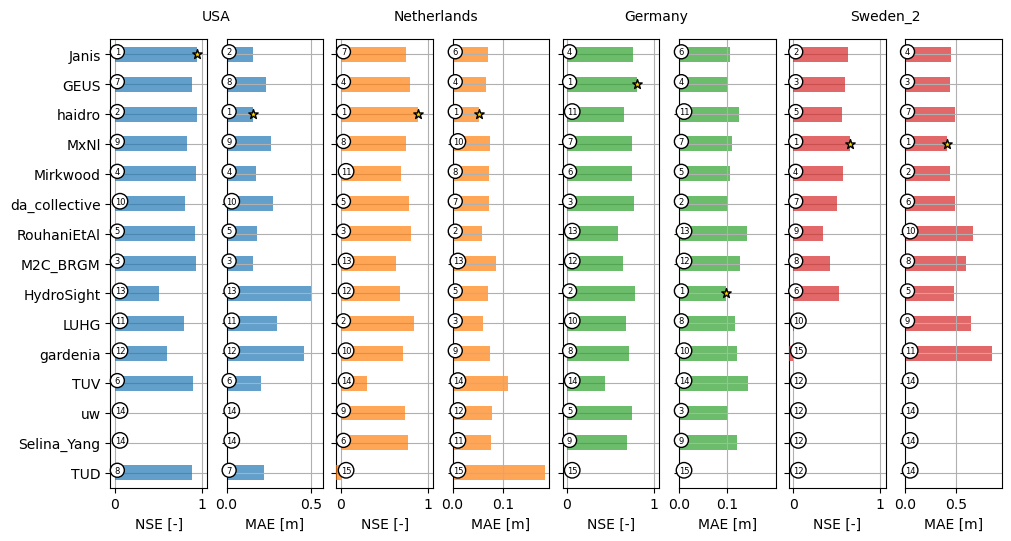

In [29]:
fig, axes = plt.subplots(1, 8, sharey=True, figsize=(10,5), constrained_layout=True)

wells_plotted = wells.drop("Sweden_1")

# Get NSE values
m1 = metrics.loc[:, (["nse"], wells_plotted)]
m1.columns = m1.columns.droplevel(0)
order = m1.fillna(0).mean(axis=1).sort_values().index

#Get MAE values
m2 = metrics.loc[:, ("mae", wells_plotted)].fillna(-1)
m2.columns = m2.columns.droplevel(0)

m1.loc[order].plot(kind="barh", subplots=True, ax=axes[0::2], legend=False, zorder=10, alpha=0.7)
m2.loc[order].plot(kind="barh", subplots=True, ax=axes[1::2], legend=False, alpha=0.7)

for i, ax in enumerate(axes):
    ax.set_title("")
    ax.grid(zorder=-10)

pos = [0.21, 0.43, 0.65, 0.88]

nse_rank = (1-m1.fillna(0)).rank()
mae_rank = m2.fillna(0).abs().rank()

for i, well in enumerate(wells_plotted):
    fig.text(pos[i], 1.03, well, ha='center')
    i = i*2
    axes[i].set_xlabel("NSE [-]")
    axes[i].set_xlim(-0.05,1.06)
    axes[i].scatter(m1.loc[order, well].max(), m1.loc[order, well].argmax(), 
                    marker="*", color="gold", zorder=200, edgecolor="k", s=50)

    for row, val in enumerate(nse_rank.loc[order, well].values):
        axes[i].text(0, row, "{:.0f}".format(val), fontsize=6, zorder=20,
                     bbox={"boxstyle" : "circle", "facecolor":"w", "edgecolor": "k"})

    axes[i+1].set_xlabel("MAE [m]")
    axes[i+1].set_xlim(0.0) #, 0.5)
    axes[i+1].scatter(m2.loc[order, well].abs().min(), m2.loc[order, well].abs().argmin(), 
                      marker="*", color="gold", zorder=20, edgecolor="k", s=50)

    for row, val in enumerate(mae_rank.loc[order, well].values):
        axes[i+1].text(0, row, "{:.0f}".format(val), fontsize=6, zorder=20,
                       bbox={"boxstyle" : "circle", "facecolor":"w", "edgecolor": "k"})

plt.savefig("../figures/metrics_nse.png", bbox_inches="tight", dpi=300)

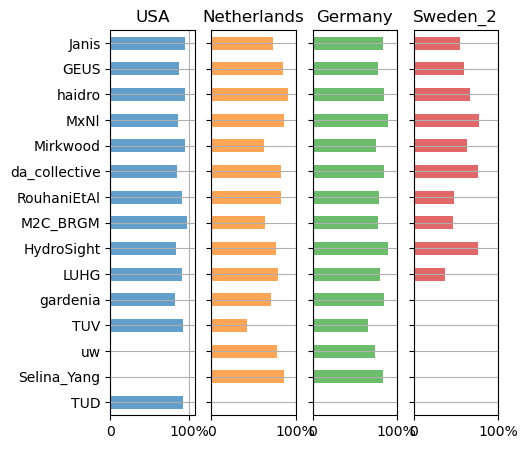

In [30]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(5,5))

wells_plotted = wells.drop("Sweden_1")
m = metrics.loc[:, (["kge_2012"], wells_plotted)].fillna(-1)
#order = m.mean(axis=1).sort_values(ascending=True).index

m.loc[order].plot(kind="barh", subplots=True, ax=axes, legend=False, alpha=0.7)

for i, well in enumerate(wells_plotted):
    axes[i].set_title(well)
    axes[i].grid()
    axes[i].set_xticks([0, 1], ["0","100%"])
    
    axes[i].set_xlim(0.0)

In [31]:
wells_plotted = df.columns.get_level_values(1).unique()
team_names = df.columns.get_level_values(0).unique()

picp = pd.DataFrame(index=team_names, columns=wells_plotted, dtype=float)

for well in wells_plotted:
    heads = pd.read_csv("../data/{}/heads_full.csv".format(well), 
                        index_col=0, parse_dates=True).squeeze().loc["2017-01-01":].dropna()
    heads.index = heads.index.round("D")    
    heads = heads.loc[~heads.index.duplicated()]
    
    for name in team_names:
        bounds = df.loc["2016":, (name, well, ["95% Lower Bound", "95% Upper Bound"])]
        nobs_between = heads.between(bounds.loc[heads.index].iloc[:,0], bounds.loc[heads.index].iloc[:,1]).sum()
        nobs = heads.index.size
        picp.loc[name, well] = nobs_between/nobs

In [32]:
picp.astype(float).round(2).style.background_gradient(cmap="RdBu")

Team,USA,Netherlands,Germany,Sweden_1,Sweden_2
da_collective,0.980000,0.870000,0.910000,0.320000,0.740000
GEUS,0.930000,0.810000,0.900000,0.190000,0.770000
Janis,0.420000,0.330000,0.360000,0.010000,0.220000
LUHG,0.950000,0.890000,0.990000,0.130000,0.780000
M2C_BRGM,0.730000,0.310000,0.390000,0.240000,0.340000
Mirkwood,0.230000,0.110000,0.070000,0.000000,0.100000
Selina_Yang,0.000000,0.750000,0.930000,0.000000,0.000000
TUD,0.050000,0.040000,0.000000,0.000000,0.000000
RouhaniEtAl,0.000000,0.000000,0.000000,0.000000,0.000000
gardenia,0.000000,0.000000,0.000000,0.000000,0.000000


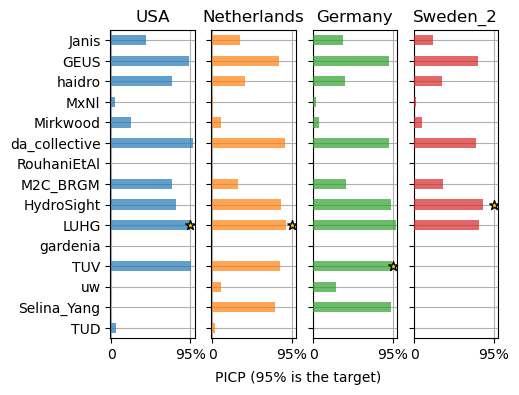

In [33]:
fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(5,4))

wells_plotted = wells.drop("Sweden_1")
m = picp.loc[:, wells_plotted]
#order = m.mean(axis=1).sort_values(ascending=True).index

m.loc[order].plot(kind="barh", subplots=True, ax=axes, zorder=10, legend=False, alpha=0.7)

for i, well in enumerate(wells_plotted):
    axes[i].set_title(well)
    axes[i].grid()
    axes[i].set_xticks([0, 0.95], ["0","95%"])
    #axes[i].scatter(0.98, (m.loc[order, well]-0.95).abs().argmin(), marker="<", color="k", zorder=10)
    axes[i].scatter(0.95, (m.loc[order, well]-0.95).abs().argmin(), 
                    marker="*", color="gold", zorder=20, edgecolor="k", s=50)
        
fig.text(0.5, 0, 'PICP (95% is the target)', ha='center')
axes[0].set_xlim(-0.01,1)

plt.savefig("../figures/metrics_picp.png", bbox_inches="tight", dpi=300)

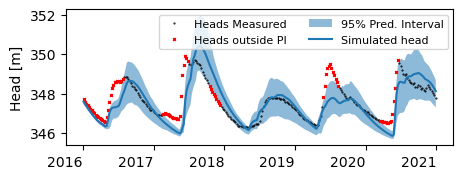

In [34]:
well = "Sweden_2"
heads = pd.read_csv("../data/{}/heads_full.csv".format(well), 
                    index_col=0, parse_dates=True).squeeze().loc["2016":].dropna()
heads.index = heads.index.round("D")
heads = heads.loc[~heads.index.duplicated()].dropna()
bounds = df.loc["2016":, ("da_collective", well, ["95% Lower Bound", "95% Upper Bound"])].dropna()
sim = df.loc["2016":, ("da_collective", well, ["Simulated Head"])].dropna()

fig, ax = plt.subplots(1,1, figsize=(5,2))

heads.plot(x_compat=True, marker=".", linestyle=" ", color="k", markersize=1)
obs_between = heads.between(bounds.loc[heads.index].iloc[:,0], bounds.loc[heads.index].iloc[:,1])
heads.loc[~obs_between].plot(marker="x", color="r", linestyle=" ", markersize=2)
ax.fill_between(bounds.index, bounds.iloc[:,0].values, bounds.iloc[:,1].values, 
                alpha=0.5)
sim.plot(ax=ax, legend=False)

plt.legend(["Heads Measured", "Heads outside PI", "95% Pred. Interval", "Simulated head"], fontsize=8, ncol=2)
ax.set_ylabel("Head [m]")
ax.set_xlabel("")
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

plt.savefig("../figures/picp_example.png", bbox_inches="tight", dpi=300)

## Effort and time investment

In [13]:
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.loc[:, (["Development time", "Calibration time"], slice(None))]
teams.head()

General Info  Development time                                 \
Team               Netherlands Germany Sweden_1 Sweden_2  USA   
da_collective              4.0     4.0      4.0      4.0  4.0   
GEUS                       2.0     2.0      2.0      2.0  2.0   
Janis                      0.5     5.0      0.5      0.5  1.0   
LUHG                       4.0     4.0      4.0      4.0  4.0   
M2C_BRGM                   5.0     5.0      5.0      5.0  5.0   

General Info  Calibration time                                              
Team               Netherlands    Germany   Sweden_1   Sweden_2        USA  
da_collective         2.000000   2.000000   2.000000   2.000000   2.000000  
GEUS                 15.000000  15.000000  15.000000  15.000000  15.000000  
Janis                 0.095833   0.086111   0.013333   0.016667   0.080278  
LUHG                  2.000000   2.000000   2.000000   2.000000   2.000000  
M2C_BRGM              0.500000   0.500000   0.500000   0.500000   0.500000

In [14]:
teams.swaplevel(0,1, axis=1)#.plot(kind="barh", subplots=True, zorder=10, legend=False, alpha=0.7, stacked=True)

Team,Netherlands,Germany,Sweden_1,Sweden_2,USA,Netherlands,Germany,Sweden_1,Sweden_2,USA
General Info,Development time,Development time,Development time,Development time,Development time,Calibration time,Calibration time,Calibration time,Calibration time,Calibration time
da_collective,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000
GEUS,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000,15.000000,15.000000,15.000000,15.000000
Janis,0.500000,5.000000,0.500000,0.500000,1.000000,0.095833,0.086111,0.013333,0.016667,0.080278
LUHG,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000
M2C_BRGM,5.000000,5.000000,5.000000,5.000000,5.000000,0.500000,0.500000,0.500000,0.500000,0.500000
Mirkwood,3.000000,3.000000,3.000000,3.000000,3.000000,1.547222,1.341667,0.505556,0.505556,0.522222
regression,NaN,4.000000,NaN,NaN,NaN,NaN,0.083333,NaN,NaN,NaN
Selina_Yang,4.000000,30.000000,NaN,NaN,NaN,0.038889,0.046667,NaN,NaN,NaN
TUD,4.000000,NaN,NaN,NaN,0.500000,48.000000,NaN,NaN,NaN,48.000000


In [15]:
teams.unstack().swaplevel(0,1)#.plot(kind="barh", subplots=True, zorder=10, legend=False, alpha=0.7, stacked=True)

Team         General Info                   
Netherlands  Development time  da_collective    4.000000
                               GEUS             2.000000
                               Janis            0.500000
                               LUHG             4.000000
                               M2C_BRGM         5.000000
                                                  ...   
USA          Calibration time  MxNl             0.016667
                               runwaygrey       0.750000
                               TUV              0.166667
                               haidro           2.000000
                               uw                    NaN
Length: 170, dtype: float64

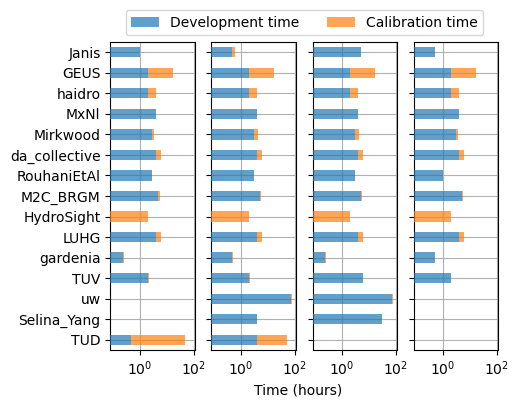

In [16]:
fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(5,4))

for ax, well in zip(axes, wells_plotted):
    teams.loc[order, (slice(None), well)].plot(kind="barh", zorder=10, ax=ax, legend=False, alpha=0.7, stacked=True, logx=True)
    ax.grid(which="major", ls="-")
    
fig.text(0.5, 0, 'Time (hours)', ha='center')
#axes[0].set_xlim(-0.01,1)1
plt.legend(["Development time", "Calibration time"], ncols=2,
           bbox_to_anchor=(-3.5,1), loc=3)

plt.savefig("../figures/metrics_time.png", bbox_inches="tight", dpi=300)

# MAE_02

In [17]:
stats = ["mae_20", "mae_80"]
wells = df.columns.get_level_values(1).unique()
team_names = df.columns.get_level_values(0).unique()

mi = pd.MultiIndex.from_product([stats, wells])
metrics2 = pd.DataFrame(index=team_names, columns=mi, dtype=float)

for i, well in enumerate(wells):
    heads = pd.read_csv("../data/{}/heads_full.csv".format(well), 
                        index_col=0, parse_dates=True).squeeze().loc["2017-01-01":].dropna()
    heads.index = heads.index.round("D")    
    heads = heads.loc[~heads.index.duplicated()]
    
    sims = df.loc[:, (slice(None), well, "Simulated Head")].astype(float)
    
    for name, ts in sims.items():
        if ts.dropna().empty:
            pass
        else:
            sim = ts.loc[ts.index.drop_duplicates()].dropna()
            idx = heads.dropna().index.intersection(sim.dropna().index)

            head = heads.loc[idx]
            
            sim = sim.loc[idx]
            
            metrics2.loc[name[0], ("mae_20", well)] = ps.stats.metrics.mae(head[head<head.quantile(0.2)], sim)
            metrics2.loc[name[0], ("mae_80", well)] = ps.stats.metrics.mae(head[head>head.quantile(0.8)], sim)

In [18]:
metrics2.head()

mae_20                                              mae_80  \
Team                USA Netherlands   Germany  Sweden_1  Sweden_2       USA   
da_collective  0.456812    0.126053  0.074055  0.392084  0.243665  0.199612   
GEUS           0.310505    0.134940  0.102580  0.321334  0.182827  0.204975   
Janis          0.145504    0.181369  0.095822  0.331173  0.407298  0.190073   
LUHG           0.359262    0.116509  0.089251  0.309732  0.134262  0.404043   
M2C_BRGM       0.237110    0.217513  0.140382  0.244097  0.712451  0.103083   

                                                         
Team          Netherlands   Germany  Sweden_1  Sweden_2  
da_collective    0.026029  0.160130  0.373486  1.027841  
GEUS             0.018544  0.120381  0.344168  1.018119  
Janis            0.017474  0.139514  0.392324  0.920081  
LUHG             0.043870  0.183447  0.403170  1.800267  
M2C_BRGM         0.016623  0.148854  0.901554  1.113150

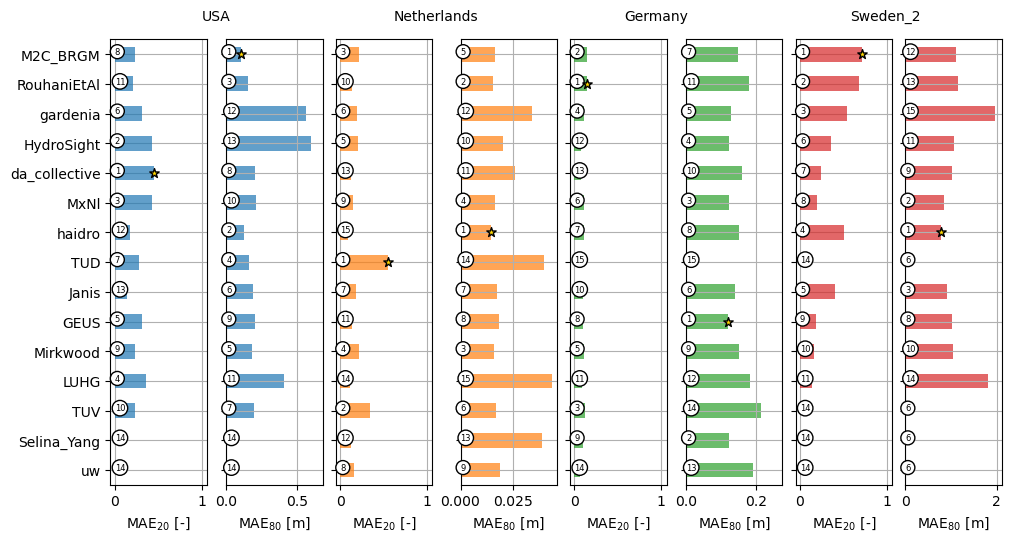

In [19]:
fig, axes = plt.subplots(1, 8, sharey=True, figsize=(10,5), constrained_layout=True)

wells_plotted = wells.drop("Sweden_1")

# Get NSE values
m1 = metrics2.loc[:, (["mae_20"], wells_plotted)]
m1.columns = m1.columns.droplevel(0)
order = m1.fillna(0).mean(axis=1).sort_values(ascending=True).index

#Get MAE values
m2 = metrics2.loc[:, ("mae_80", wells_plotted)].fillna(-1)
m2.columns = m2.columns.droplevel(0)

m1.loc[order].plot(kind="barh", subplots=True, ax=axes[0::2], legend=False, zorder=10, alpha=0.7)
m2.loc[order].plot(kind="barh", subplots=True, ax=axes[1::2], legend=False, alpha=0.7)

for i, ax in enumerate(axes):
    ax.set_title("")
    ax.grid(zorder=-10)

pos = [0.21, 0.43, 0.65, 0.88]

nse_rank = (1-m1.fillna(0)).rank()
mae_rank = m2.fillna(0).abs().rank()

for i, well in enumerate(wells_plotted):
    fig.text(pos[i], 1.03, well, ha='center')
    i = i*2
    axes[i].set_xlabel("MAE$_{20}$ [-]")
    axes[i].set_xlim(-0.05,1.06)
    axes[i].scatter(m1.loc[order, well].max(), m1.loc[order, well].argmax(), 
                    marker="*", color="gold", zorder=200, edgecolor="k", s=50)

    for row, val in enumerate(nse_rank.loc[order, well].values):
        axes[i].text(0, row, "{:.0f}".format(val), fontsize=6, zorder=20,
                     bbox={"boxstyle" : "circle", "facecolor":"w", "edgecolor": "k"})

    axes[i+1].set_xlabel("MAE$_{80}$ [m]")
    axes[i+1].set_xlim(0.0) #, 0.5)
    axes[i+1].scatter(m2.loc[order, well].abs().min(), m2.loc[order, well].abs().argmin(), 
                      marker="*", color="gold", zorder=20, edgecolor="k", s=50)

    for row, val in enumerate(mae_rank.loc[order, well].values):
        axes[i+1].text(0, row, "{:.0f}".format(val), fontsize=6, zorder=20,
                       bbox={"boxstyle" : "circle", "facecolor":"w", "edgecolor": "k"})

plt.savefig("../figures/metrics_mae.png", bbox_inches="tight", dpi=300)

(2401.0, 2662.0)

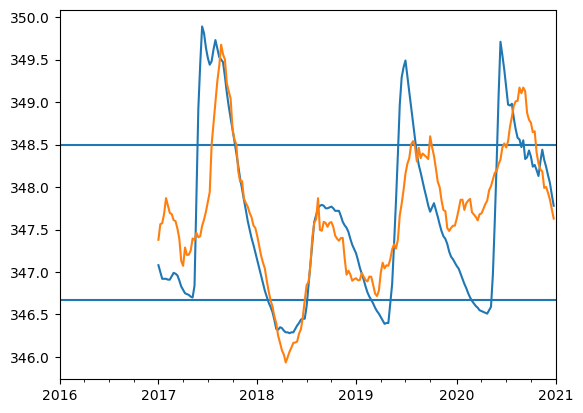

In [20]:
ax = head.plot()
ax.axhline(head.quantile(0.2))
ax.axhline(head.quantile(0.8))
sim.plot(ax=ax)#, x_compat=True)
plt.xlim("2016", "2021")

In [21]:
ps.stats.metrics.nse(head, sim)

0.5601676242903134

In [22]:
sim

2017-01-03    347.37927
2017-01-10    347.56310
2017-01-17    347.57404
2017-01-24    347.68555
2017-01-31    347.87024
                ...    
2020-12-01    348.00125
2020-12-08    347.93283
2020-12-15    347.85315
2020-12-22    347.73917
2020-12-29    347.62870
Name: (haidro, Sweden_2, Simulated Head), Length: 209, dtype: float64